Korenaga 2011
======

Temperature dependent convection
----

This Notebooks implements the case of two-dimensional, incompressible, internally-heated fmantle convection.


**Keywords:** Stokes system, advective diffusive systems, analysis tools, tools for post analysis, rheologies


**References**

Korenaga, Jun. "Scaling of plate tectonic convection with pseudoplastic rheology." Journal of Geophysical Research: Solid Earth 115.B11 (2010).
http://onlinelibrary.wiley.com/doi/10.1029/2010JB007670/full

In [7]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

Model name and directories
-----

In [8]:
############
#Model name.  
############
Model = "T"
ModNum = 3

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [9]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [10]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/3/Base/checkpoint/ is empty


Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [11]:
#u = pint.UnitRegistry()
#cmpery = u.cm/u.year
#mpermy = u.m/u.megayear

#cmpery.to(mpermy)

**Set parameter dictionaries**

In [12]:
#dimensional parameter dictionary
dp = edict({'LS':2900.*1e3,
           'rho':3300,
           'g':9.8, 
           #'eta0':1e21,    #This will give Ra ~ 2e7, closer to models by Van Hunen, Billen etc.
           'eta0': 2.12e22, #This will give Ra = 1e6 as quoted on Korenaga's paper
           'k':1e-6,
           'a':2e-5, 
           'deltaT':1350, #Hunen
           'TS':273.,
           'cohesion':21e6,
           'fc':0.02,
           'E':240000.,
           'R':8.314})

dp['TI'] = dp.TS + dp.deltaT


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(dp.rho*dp.g*dp.LS)/(dp.R*dp.deltaT), #This is the activation energy scale, in terms of depth (not pressure)
            'E': 1./(dp.R*dp.deltaT)})

#dimensionless parameters


ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT*(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'gamma':dp.fc/(dp.a*dp.deltaT),
            'E':dp.E*sf.E,
            'TSP':0., 
            'TIP':1.,
            'n':1.,
            'TS':dp.TS/dp.deltaT,
            'TI':dp.TI/dp.deltaT,
            'eta_min':1e-3,
            'eta_max':1e5,
            'H':20.,
            'Tmvp':0.6})



#ndp.RA = 1e6 #this is what Korenaga sets it to

dp.VR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.)) #characteristic velocity
dp.SR = dp.VR/dp.LS #characteristic strain rate

ndp.VR = dp.VR*sf.vel #characteristic velocity
ndp.SR = dp.SR*sf.SR #characteristic strain rate

In [13]:
#(dp.g*dp.rho*dp.a*dp.deltaT*(dp.LS)**3)/(dp.k*1e6)
ndp.RA

1004527.6896226417

In [14]:
#hDim = 5.44e-12 #crameri and tackley
#hDim = 2.47e-11 #Turcott and Schubert
#tc = 3
#Ts = (dp.rho*hDim*dp.LS**2)/tc

#RAh = Ts*(dp.a*dp.g*dp.rho*(dp.LS**3))/(dp.k*dp.eta0)
#print(Ts, RAh)

In [15]:
#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (20.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (900.*1e3)/dp.LS 
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (0.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TIP #Used to define lithosphere


**Model setup parameters**

In [16]:
###########
#Model setup parameters
###########

refineMesh = False
stickyAir = False 
arrhenius = True
lower_mantle = False
melt_viscosity_reduction= False



MINX = -2.
MINY = 0.
MAXX = 2.

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 92


Xres = int(RES*4)


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [True, False]
#elementType = "Q1/dQ0"
elementType ="Q2/DPC1"


#System/Solver stuff

PIC_integration=True
ppc = 25

#Output and safety stuff

swarm_repop, swarm_update = 10, 10
gldbs_output = 50
checkpoint_every, files_output = 50, 50
metric_output = 10

Create mesh and finite element variables
------

In [17]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY))
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Initial conditions
-------


**Plot initial temperature**

In [18]:
coordinate = fn.input()
depthFn = 1. - coordinate[1]

In [19]:
if not checkpointLoad:
    # Setup temperature initial condition via numpy arrays
    A = 0.2
    #Note that width = height = 1
    pertCoeff = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
    temperatureField.data[:] = pertCoeff.evaluate(mesh)  

In [20]:
if not checkpointLoad:
    random_temp_fac = 0.05
    for index, coord in enumerate(mesh.data):
        pertCoeff = (random_temp_fac *(np.random.rand(1)[0] - 0.5)) #this should create values between [-0.5,0.5] from uniform dist.
        temperatureField.data[index] += pertCoeff

In [21]:
figtemp = glucifer.Figure()
figtemp.append( glucifer.objects.Surface(mesh, temperatureField) )

#figtemp.show()
#figtemp.save_database('test.gldb')

**Boundary conditions**

In [22]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TIP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]


freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



Particles
-----


In [23]:
###########
#Material Swarm and variables
###########


gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
tracerVariable = gSwarm.add_variable( dataType="int", count=1)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
timeVariable = gSwarm.add_variable( dataType="float", count=1 )




In [24]:
varlist = [tracerVariable, tracerVariable, yieldingCheck]

varlist = [materialVariable, yieldingCheck, timeVariable]
varnames = ['materialVariable', 'yieldingCheck', 'timeVariable']

In [25]:
mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
eclIndex = 3


if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Swarm variables
    materialVariable.data[:] = mantleIndex
    tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    timeVariable.data[:] = 0.
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

**Passive tracer layout**

In [26]:
#Passive tracers are not included in checkpoint - Probably best to remove this once models are properly bugchecked

square_size = 0.1

xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 

tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

**Material swarm and graphs**

In [27]:

##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]

In [28]:
#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

materialVariable.data[:] = 0

#######Graph object
#DG = nx.DiGraph(field="Depth")
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)


#Anything to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, CRUSTTOMANTLE)

#Anything to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, MANTLETOCRUST)

#Anything to lithsphere
#DG.add_transition((mantleIndex,lithosphereIndex), depthFn, operator.lt, MANTLETOLITH)
#DG.add_transition((mantleIndex,lithosphereIndex), temperatureField, operator.lt, 0.85*AVGTEMP)


#crust to eclogite
#DG.add_edges_from([(3,2)])
#DG[3][2]['depthcondition'] =CRUSTTOECL
#DG.add_transition((3,2), depthFn, operator.gt, CRUSTTOECL)

In [29]:
#dummyData = np.copy(materialVariable.data)#This is part of a hack that resets ages when a material type changes

DG.build_condition_list(materialVariable)
for i in range(2): #Need to go through twice first time through
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
    
#timeVariable.data[np.where(dummyData[:] != materialVariable.data[:])] = 0. #resets those ages when a material type change
#np.unique(timeVariable.data)

In [30]:
fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, dummyField))
#fig.show()

Set up material parameters and functions
-----

Setup the viscosity to be a function of the temperature. Recall that these functions and values are preserved for the entire simulation time. 

In [31]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))


theta = (dp.E *dp.deltaT)/(dp.R*(dp.TS + dp.deltaT)**2)

gamma = dp.fc/(dp.a*dp.deltaT)
print(theta, gamma )


(14.794420225563012, 0.7407407407407407)


In [53]:
#overide these parameters to match the reference case quoted on page 5
theta = 15.
gamma = 0.6
ndp.E = 2.5



In [54]:
############
#Rheology
#############
#
#The final mantle rheology is composed as follows*:
# 
#
# mantleviscosityFn = max{  min{(1/omega*nonlinearVisc + 1/eta_p)**-1,
#                           eta_max},
#                           eta_min}
#                      
#nonlinearVisc => FK viscosity (could be linear or non linear)
#eta_p   => stress-limiting effective viscosity
#


omega = fn.misc.constant(1.)

if melt_viscosity_reduction:
    mvr =  fn.branching.conditional( [ (temperatureField > (ndp.Tmvp + 7.5*(1. - coordinate[1])) , 0.1 ),   (         True, 1.) ] )
    omega = omega*mvr


#implementation of the lower mantle viscosity increase, similar to Bello et al. 2015
a = 1.
B = 30.
d0 = 660e3/dp.LS  
ds = d0/10.
if lower_mantle:
    inner1 = 1. - 0.5*(1. - fn.math.tanh(((1. - d0)-(coordinate[1]))/(ds)))
    modfac = a*fn.math.exp(np.log(B)*inner1)
    omega = omega*modfac



linearVisc = fn.math.exp(theta*(1. - temperatureField))
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.n)/(ndp.n))
nonlinearVisc = omega*nl_correction*linearVisc
if arrhenius:
    nonlinearVisc = fn.misc.min(ndp.eta_max, omega*fn.math.exp(((ndp.E)/(ndp.n*(temperatureField + ndp.TS))) 
                                                        - ((ndp.E )/(ndp.n*(ndp.TIP + ndp.TS)))))

ys =  (gamma*ndp.RA*1e-5) + (depthFn*gamma*ndp.RA) #tau_1 * 1e-5 is the cohesion value used in the paper
if arrhenius:
    ys =  ndp.cohesion + (depthFn*gamma*ndp.RA) #In this case we'll use a more standard cohesion
yielding = ys/(strainRate_2ndInvariant/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


mantleviscosityFn = fn.misc.max(fn.misc.min(1./(((1./nonlinearVisc) + (1./yielding))), ndp.eta_max), ndp.eta_min)


##Crust rheology
ysc = ys
#ysc = ys*0.1
crust_yielding = ys/(strainRate_2ndInvariant/math.sqrt(0.5)) #extra factor to account for underworld second invariant form
crustviscosityFn = fn.misc.max(fn.misc.min(1./(((1./nonlinearVisc) + (1./crust_yielding))), ndp.eta_max), ndp.eta_min)


In [61]:
(2/16.)*dp.LS, (0.06)*dp.LS

(362500.0, 174000.0)

**Plot the initial viscosity**

Plot the viscosity, which is a function of temperature, using the initial temperature conditions set above.


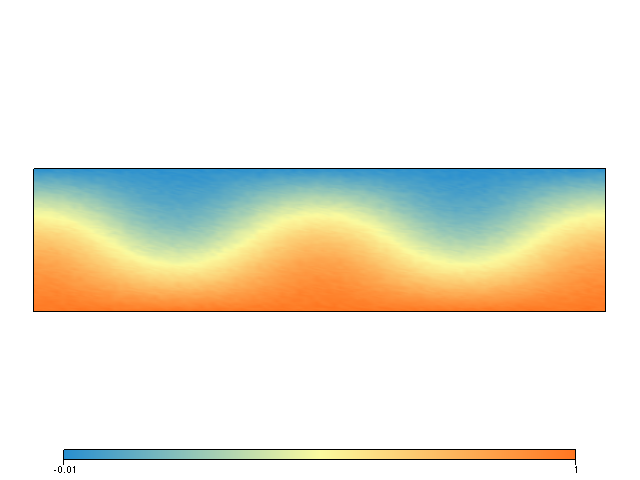

In [57]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Surface(mesh, temperatureField, logScale=False) )
#figEta.save_database('test.gldb')
figEta.show()

System setup
-----

Since we are using a previously constructed temperature field, we will use a single Stokes solve to get consistent velocity and pressure fields.

**Setup a Stokes system**

In [91]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:crustviscosityFn,
                                    mantleIndex:mantleviscosityFn, 
                                    eclIndex:mantleviscosityFn} )

In [92]:
# Construct our density function.
densityFn = ndp.RA * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * gravity

In [93]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=linearVisc, 
                              fn_bodyforce=buoyancyFn )

**Set up and solve the Stokes system**

In [94]:
solver = uw.systems.Solver(stokesPIC)
solver.solve()

**Add the non-linear viscosity to the Stokes system**


In [95]:
stokesPIC.fn_viscosity = viscosityMapFn

In [96]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 2.2418e+00
Pressure solve time: 2.5832e-01
Velocity solve time: 2.2333e+00 (backsolve)
Total solve time   : 5.0508e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



**Create an advective diffusive system**

In [97]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 20.0,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [neumannTempBC, dirichTempBC] )

passiveadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [98]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

Analysis tools
-----

In [116]:
#These are functions we can use to evuate integrals over restricted parts of the domain
# For instance, we can exclude the thermal lithosphere from integrals

def temprestrictionFn(lithval = 0.9):

    tempMM = fn.view.min_max(temperatureField)
    tempMM.evaluate(mesh)
    TMAX = tempMM.max_global()
    mantleconditions = [ (                                  temperatureField > lithval*TMAX, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(mantleconditions)

mantlerestrictFn = temprestrictionFn(lithval = 0.85)



def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srrestrictFn = platenessFn(val = 0.1)

In [117]:
#fig = glucifer.Figure()
#fig.append( glucifer.objects.Surface(mesh, mantlerestrictFn) )

#fig.show()
#fig.save_database('test.gldb')

'test.gldb'

In [107]:
#Setup volume integrals 

tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vdint = uw.utils.Integral( (4.*viscosityMapFn*sinner), mesh )

mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
mantleVisc = uw.utils.Integral( mantleviscosityFn*mantlerestrictFn, mesh )
mantleVd = uw.utils.Integral( (4.*viscosityMapFn*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions

In [101]:
#Setup surface integrals

rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

plateint  = uw.utils.Integral( fn=srrestrictFn, mesh=mesh, integrationType='Surface', #Integrate the plateness function
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]) 

surfint  = uw.utils.Integral( fn=1., mesh=mesh, integrationType='Surface',   #Surface length function (i.e. domain width)
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

In [102]:
#Define functions for the evaluation of integrals

def basic_int(ourIntegral):           #This one just hands back the evaluated integral
    return ourIntegral.evaluate()[0]

def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()


def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [103]:
#v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
#volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
#Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]



#if(uw.rank()==0):
#    print('Initial Vrms = {0:.3f}'.format(Vrms))

In [55]:
# Check the Metrics

#Avg_temp = avg_temp()
#Rms = rms()
#Rms_surf = rms_surf()
#Max_vx_surf = max_vx_surf(velocityField, mesh)
#Gravwork = basic_int(dwint)
#Viscdis = basic_int(vdint)
#nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
#etamax, etamin = visc_extr(mantleviscosityFn)

#Area_mantle = basic_int(mantleArea)
#Viscmantle = basic_int(mantleVisc)
#Tempmantle = basic_int(mantleTemp)
#Viscdismantle = basic_int(mantleVd)

In [60]:
#Tempmantle/Area_mantle, Viscmantle/Area_mantle
#Plateness = basic_int(plateint)/basic_int(surfint)

Viz.
-----

In [66]:
#tracerVariable.data

In [67]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
figDb.append( glucifer.objects.Surface(mesh, mantleviscosityFn, logScale=True))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))
#figDb.show()

In [68]:

def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((17*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness ))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    

**Miscellania**

In [34]:
surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity


normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



In [36]:
tempMM.max_global(), temperatureField.data.max()

(1.0890113793298568, 1.0890113793298568)

Main simulation loop
-----

Run a few advection and Stokes solver steps to make sure we are in, or close to, equilibrium.

In [70]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

In [459]:
#while step < 21:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    passiveadvector.integrate(dt)
    

    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0):
        #Rebuild any necessary swarm variables
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        #figDb.show()
        figDb.save_database(fullpath)
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(ModIt) + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
    ################            
    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        # Calculate the RMS velocity and Nusselt number.
        # Calculate the Metrics, only on 1 of the processors:
        mantlerestrictFn = temprestrictionFn() #rebuild the mantle restriction function (but these should be dynamic?)
        srrestrictFn = platenessFn(val = 0.1) #rebuild the plateness restriction function
        dummy = tempMM.evaluate(mesh) #Re-evaluate any fn.view.min_max guys
        #Rebuild these integrals (a test because metrics changes after a restart)
        mantleArea   = uw.utils.Integral( mantlerestrictFn, mesh )
        mantleTemp = uw.utils.Integral( temperatureField*mantlerestrictFn, mesh )
        mantleVisc = uw.utils.Integral( mantleviscosityFn*mantlerestrictFn, mesh )
        mantleVd = uw.utils.Integral( (4.*viscosityMapFn*sinner*mantlerestrictFn), mesh ) #these now work on MappingFunctions
        ###
        Avg_temp = avg_temp()
        Rms = rms()
        Rms_surf = rms_surf()
        Max_vx_surf = max_vx_surf(velocityField, mesh)
        Gravwork = basic_int(dwint)
        Viscdis = basic_int(vdint)
        nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
        etamax, etamin = visc_extr(mantleviscosityFn)
        Area_mantle = basic_int(mantleArea)
        Viscmantle = basic_int(mantleVisc)
        Tempmantle = basic_int(mantleTemp)
        Viscdismantle = basic_int(mantleVd)
        Plateness = basic_int(plateint)/basic_int(surfint)
        TMAX = tempMM.max_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((17*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp,
                                              Tempmantle,TMAX,
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin, 
                                              Area_mantle, Viscmantle,  Viscdismantle,Plateness ))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()
    
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
    ################
    #Particle update
    ###############
    timeVariable.data[:] += dt #increment the ages (is this efficient?)
    dummyData = np.copy(materialVariable.data)#This is part of a hack that resets ages when a material type changes
    if step % swarm_update == 0:
        for i in range(2): #Need to go through twice first time through
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
    timeVariable.data[np.where(dummyData[:] != materialVariable.data[:])] = 0. #resets those ages when a material type change
    
f_o.close()
print 'step =',step

ValueError: I/O operation on closed file